In [3]:
import os
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Paths
data_dir = 'chest_xray'
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')  # We'll merge this into train
test_path = os.path.join(data_dir, 'test')

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 1. Merge train + val folders temporarily
# Load both datasets
merged_train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset_to_merge = datasets.ImageFolder(val_path, transform=train_transform)

# Concatenate them manually
merged_train_dataset.samples.extend(val_dataset_to_merge.samples)
merged_train_dataset.targets.extend(val_dataset_to_merge.targets)

# 2. Stratified split
labels = merged_train_dataset.targets
indices = list(range(len(merged_train_dataset)))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.15,  # 15% validation split
    stratify=labels,
    random_state=42
)

# 3. Create subsets
train_dataset = Subset(merged_train_dataset, train_idx)
val_dataset = Subset(merged_train_dataset, val_idx)

# 4. Load test data as-is
test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

# 5. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 6. Print new sizes
print("New dataset sizes:")
print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))
print("Class mapping:", merged_train_dataset.class_to_idx)


New dataset sizes:
Train: 4447 Val: 785 Test: 624
Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


Visualization Function

Sample images from training set:


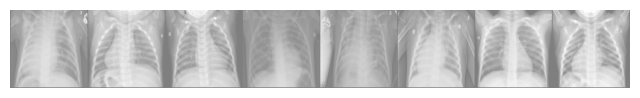

In [4]:
def imshow(img):
    img = img * 0.5 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

# Show some training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("Sample images from training set:")
imshow(torchvision.utils.make_grid(images[:8]))

resNet model setup

In [9]:
model = models.resnet50(pretrained=True)

# Modify first conv layer to accept 1 input channel instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s] 


Loss and optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Training Loop

In [18]:
train_losses = []
train_accuracies = []
val_accuracies = []
num_epoch = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/5], Loss: 0.0299, Train Acc: 0.9883, Val Acc: 0.9375
Epoch [2/5], Loss: 0.0468, Train Acc: 0.9841, Val Acc: 1.0000
Epoch [3/5], Loss: 0.0361, Train Acc: 0.9875, Val Acc: 0.8750
Epoch [4/5], Loss: 0.0389, Train Acc: 0.9859, Val Acc: 0.9375
Epoch [5/5], Loss: 0.0306, Train Acc: 0.9872, Val Acc: 1.0000


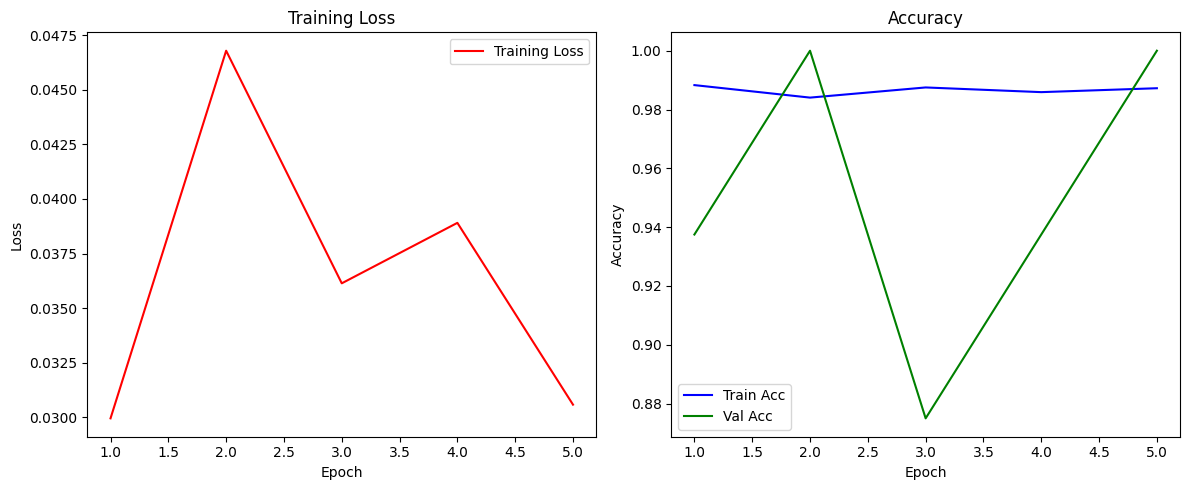

In [19]:
# Plot accuracy and loss
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Acc')
plt.plot(epochs, val_accuracies, 'g-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


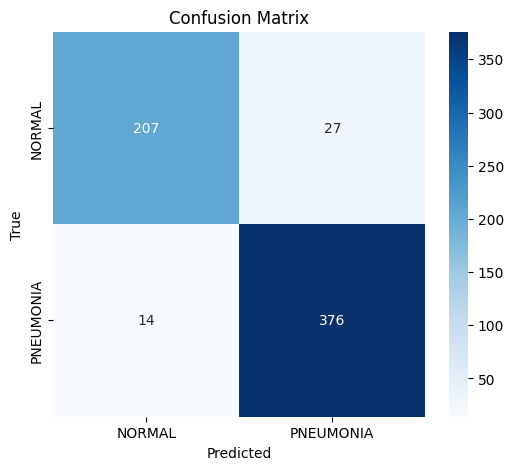

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.88      0.91       234
   PNEUMONIA       0.93      0.96      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624



In [20]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = list(train_dataset.class_to_idx.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


In [13]:
torch.save(model.state_dict(), "resnet50_chestxray.pth")
print("Model saved as resnet50_chestxray.pth")

Model saved as resnet50_chestxray.pth


In [12]:
!nvidia-smi


Wed May 14 19:01:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.04              Driver Version: 555.52.04      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:20:00.0 Off |                  N/A |
| 31%   49C    P2             91W /  250W |   10053MiB /  11264MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----